In [1]:
import numpy as np
import pandas as pd
import os
import glob
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


from itables import show
from src.model.SimpleMILModels import Attention, MaxMIL, AttentionResNet
from src.dataloaders.DataLoaders import RetCCLFeatureLoader, RetCCLFeatureLoaderMem


import zarr
import seaborn as sns

Here, we will take the training model for each samples where the sample ends up in the test fold, and try to infer the attn maps efficiently on the CPU.

In [2]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [3]:
group = "BGUAJ0"

In [4]:

api = wandb.Api()


In [5]:
runs = api.runs(path="psmirnov/UKHD_RetCLL_299_CT", filters={"group": group})

Load in the features (not too much memory needed)

In [6]:
path_to_extracted_features = '/home/p163v/histopathology/UKHD_Neuro/RetCLL_Features/' 



slide_meta = pd.read_csv("../metadata/labels_with_new_batch.csv")
ct_scoring = pd.read_csv("../metadata/CT_3_Class_Draft.csv")

slide_meta_wbt = wandb.Table(dataframe=slide_meta)
ct_scoring_wbt = wandb.Table(dataframe=ct_scoring)

labels_artifact = wandb.Artifact("dataset_labels", type="labels")
labels_artifact.add(slide_meta_wbt, "slide_meta")
labels_artifact.add(ct_scoring_wbt, "ct_scoring")

ct_scoring["txt_idat"] = ct_scoring["idat"].astype("str")
ct_scoring.index = ct_scoring.txt_idat
slide_meta.index = slide_meta.idat
ct_scoring = ct_scoring.drop("txt_idat", axis=1)
slide_meta = slide_meta.drop("idat", axis=1)
slide_annots = slide_meta.join(ct_scoring, lsuffix="l")


slide_annots['file'] = slide_annots.uuid + ".h5"

slide_annots.index = slide_annots.uuid


splits = os.listdir('/home/p163v/histopathology/splits/02022024/')
splits.sort()


# all_files = [x for x in slide_annots.file if os.path.isfile(path_to_extracted_features + "/" + x)]

# all_features = {file: h5py.File(path_to_extracted_features + "/" + file, 'r')['feats'][:] for file in all_files}

# Loss

We use the loss as the early stopping criteria


In [15]:
testing_slides = list()
testing_labels = list()
testing_probs = list()
testing_preds = list()
testing_attn = list()
testing_cv = list()
testing_superfamily = list()
cv =  lambda x: np.std(x) / np.mean(x)

In [23]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version).split('-')[0]: a for a in arts}
    # testing_slides.append(arts_dict['fold'].get('testing').get_dataframe())
    checkpoint_folder_name = arts_dict['model'].name.split('-')[1].removesuffix(':'+arts_dict['model'].version)
    args = runs[0].config

    test_features = [h5py.File(path_to_extracted_features + "/" + file + ".h5", 'r')['feats'][:] for file in testing_slides[ii].iloc[:,0]]


    test_df = slide_annots.loc[testing_slides[ii][0]]
    testing_labels.append(np.abs(1-test_df.CT_class.factorize(sort=True)[0]))
    testing_preds.append(arts_dict['preds_loss'].get('testing').get_dataframe())
    testing_probs.append(arts_dict['preds_loss'].get('testing_probs').get_dataframe())

    test_data = RetCCLFeatureLoaderMem(test_features, test_labels, patches_per_iter='all')

    args['attention_dim']

    model = Attention(2048, lr=args['lr'], weight_decay=args['weight_decay'], hidden_dim=args['hidden_dim'], attention_dim=args['attention_dim'], class_weights=torch.tensor(float(args['class_weights'])))

    chkpt_file = glob.glob('lightning_logs/'+checkpoint_folder_name+'/checkpoints/best_loss*')[0]

    model = model.load_from_checkpoint(chkpt_file, map_location=torch.device('cpu'))

    model.eval()

    RetCCLTest = DataLoader(test_data, batch_size=1, num_workers=1)#, sampler=valid_Sampler)

    model_attention = [model.attention_forward(torch.tensor(x).to(model.device)).detach().cpu().numpy() for x,y in iter(RetCCLTest)]


    ## First, just write out the per-tile attention to zarr files
    for jj in range(len(np.array(testing_slides[ii]))):
        slidename = np.array(testing_slides[ii])[jj].item()
        print('Writing Attention Map ' + slidename)
        coords = h5py.File(path_to_extracted_features + "/" + slidename + ".h5", 'r')['coords'][:]
        outarray_root = zarr.open("/home/p163v/histopathology/attention_maps/"+ group + "/"+ slidename + "_per_tile_attention.zarr", mode='w') 
        outarray_root['coords'] = coords
        outarray_root['attn'] = model_attention[jj][0,0,:]
    testing_cv.append([cv(np.array(x)) for x in model_attention])
    testing_superfamily.append(test_df.max_super_family_class)

wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  


In [40]:
cv_all = np.concatenate(testing_cv)
label_all = np.concatenate(testing_labels)
pred_all = np.concatenate(testing_preds)
prob_all = np.concatenate(testing_probs)
slides_all = np.concatenate(testing_slides)

<Axes: ylabel='Count'>

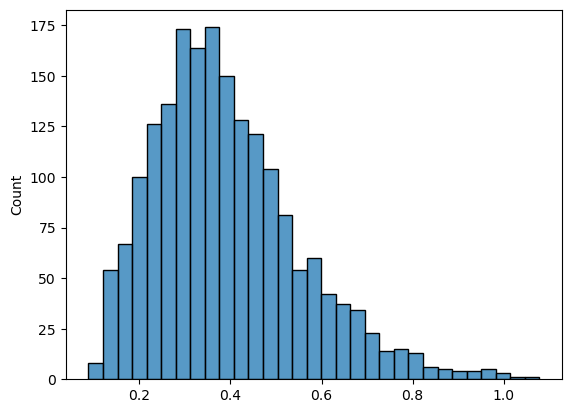

In [18]:
sns.histplot(cv_all)

In [41]:
slides_all[cv_all>1]

array([['902C256C-22E5-427E-9FAF-CAA206CE46C1'],
       ['F43222AB-5352-491B-9906-1100A046795D'],
       ['95C1EFE3-112A-48EF-A15C-F7A39AC13247']], dtype=object)

In [55]:
slides_all[cv_all<0.1]

array([['64F3A170-DF3D-46D7-828C-58C8C5979C88'],
       ['D46198C6-C16E-4A8E-89A6-792E9937A27B']], dtype=object)

In [43]:
np.concatenate(testing_superfamily)[cv_all>1]

array(['Adult-type diffuse gliomas', 'Adult-type diffuse gliomas',
       'Paediatric-type diffuse high-grade gliomas'], dtype=object)

In [51]:
(label_all != pred_all.reshape(-1))[cv_all>1]

array([ True, False,  True])

Here is what to do next:
1. examine these slides manually
2. make their attentionmaps 
3. look at some cases of very little attn map heterogeneity
4. make meeting with Ramin
5. 


In [33]:
np.mean((label_all != pred_all)[np.concatenate(testing_superfamily)=='Medulloblastoma'])


0.42986685766175964

Sanity Check:

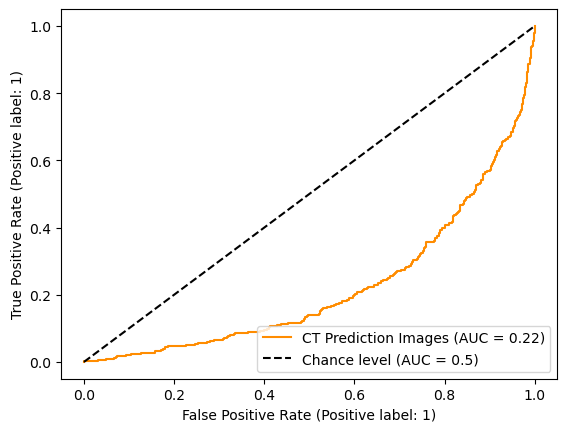

In [35]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    label_all,
    prob_all,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)

# Lets look into subgroup analysis

In [125]:
pd.Series(test_superfamily).value_counts()

Ependymal tumours                                            325
Adult-type diffuse gliomas                                   253
Low-grade glial/glioneuronal/neuroepithelial tumours         248
tumours of the sellar region                                 149
Medulloblastoma                                              123
meningioma                                                   119
Cranial and paraspinal nerve tumours                         101
Control tissues                                              100
Mesenchymal, non-meningothelial tumours involving the CNS     92
Other CNS embryonal tumours                                   64
Paediatric-type diffuse high-grade gliomas                    64
Pineal parenchymal and retinal tumours                        35
diffuse glioma, MAPK altered, cell-cycle activated            34
Circumscribed astrocytic tumours                              27
choroid plexus tumours                                        26
Germ cell tumours        

In [141]:
show(pd.DataFrame(slide_annots.loc[slide_annots.CT_class != "Unsure"].groupby('max_super_family_class').CT_class.value_counts()))

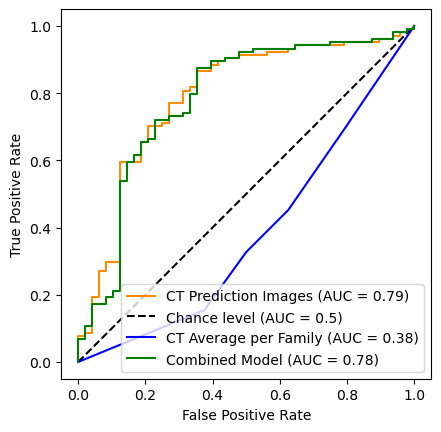

In [103]:
glioblasoma_indices = test_family=="glioblastoma"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices],
    test_probs[glioblasoma_indices],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices][~np.isnan(test_mean)[glioblasoma_indices]],
    test_mean[glioblasoma_indices][~np.isnan(test_mean)[glioblasoma_indices]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices][~np.isnan(test_mean)[glioblasoma_indices]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[glioblasoma_indices[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

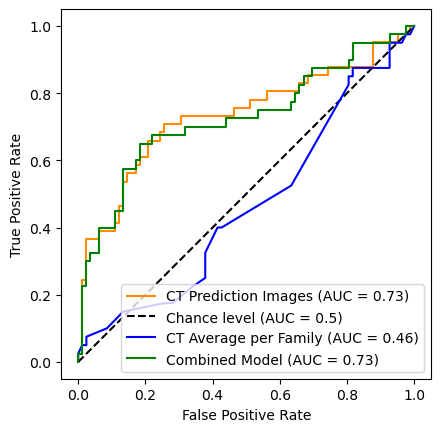

In [126]:
medullo_indicies = test_superfamily == 'Medulloblastoma'


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[medullo_indicies],
    test_probs[medullo_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    test_mean[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[medullo_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

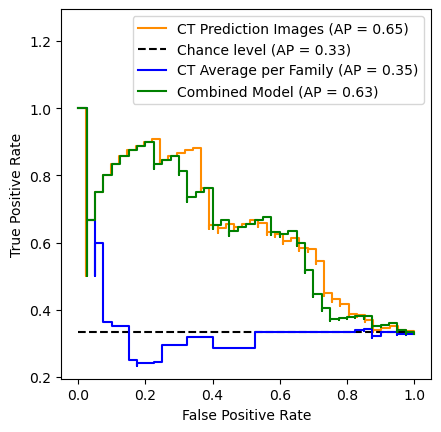

In [147]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[medullo_indicies],
    test_probs[medullo_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    test_mean[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[medullo_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [155]:
medullo_indicies.sum()

123

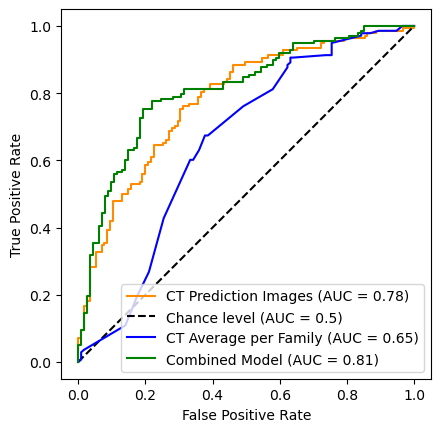

In [127]:
difglioma_indicies = test_superfamily == 'Adult-type diffuse gliomas'


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[difglioma_indicies],
    test_probs[difglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    test_mean[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[difglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

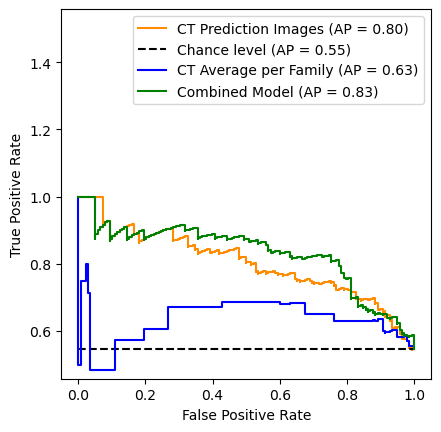

In [148]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[difglioma_indicies],
    test_probs[difglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    test_mean[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[difglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [154]:
difglioma_indicies.sum()

253

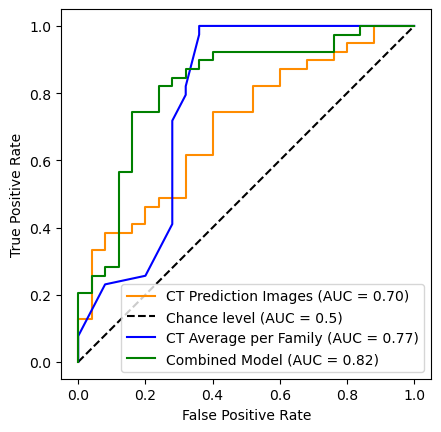

In [152]:
peddifglioma_indicies = test_superfamily == "Paediatric-type diffuse high-grade gliomas"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[peddifglioma_indicies],
    test_probs[peddifglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    test_mean[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[peddifglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [153]:
peddifglioma_indicies.sum()


64

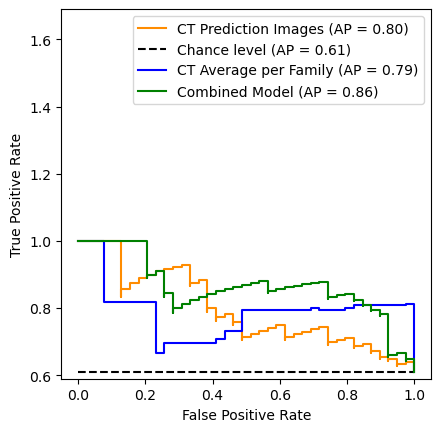

In [150]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[peddifglioma_indicies],
    test_probs[peddifglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    test_mean[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[peddifglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [146]:
len(test_labels)

1907

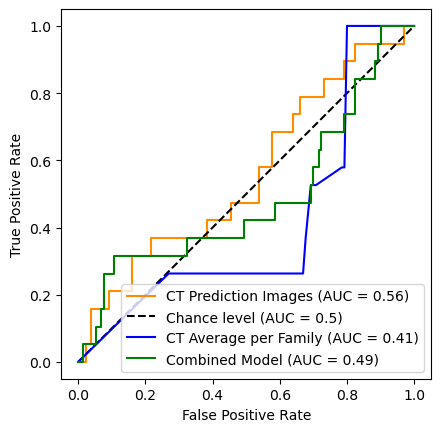

In [143]:
sellar_indicies = test_superfamily == "tumours of the sellar region"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[sellar_indicies],
    test_probs[sellar_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    test_mean[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[sellar_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

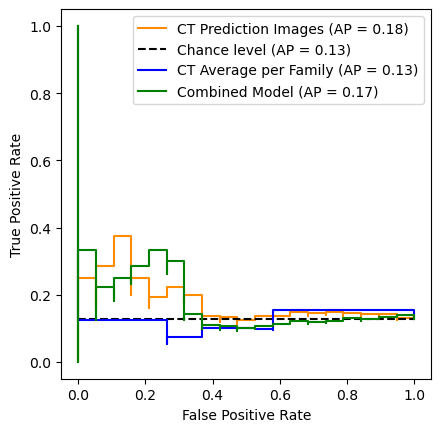

In [156]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[sellar_indicies],
    test_probs[sellar_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    test_mean[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[sellar_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [157]:
sellar_indicies.sum()

149

In [145]:
slide_annots[slide_annots.CT_class != "Unsure"]

,uuid,tumor_id,txt_LOKALISATION,num_ALTERSANGABE,patient_id,max_super_family_class,max_family_class,max_class,max_subclass,relevant Histo prediction,...,classifciation_v11,max_cal_v11,family,file_path,slide,Unnamed: 0,idat,CT_class,file,labels
uuid,,,,,,,,,,,,,,,,,,,,,
1EE2D6AD-2F2A-4457-BA86-4CC8D137249D,1EE2D6AD-2F2A-4457-BA86-4CC8D137249D,73896,"infratentoriell, sakral",30.0,4981,Ependymal tumours,myxopapillary ependymoma,myxopapillary ependymoma,Myxopapillary ependymoma,Myxopapillary ependymoma,...,"methylation class ependymoma, myxopapillary",0.996477,ependymoma,/omics/odcf/analysis/OE0606_projects/pancancer...,1EE2D6AD-2F2A-4457-BA86-4CC8D137249D,41.0,10003886253_R02C02,Chromothripsis,1EE2D6AD-2F2A-4457-BA86-4CC8D137249D.h5,1
9625ECC7-5AA1-4ADF-B99E-B2F959A2317E,9625ECC7-5AA1-4ADF-B99E-B2F959A2317E,73878,"spinal, TH 11/12 extramedullär",71.0,5395,"Mesenchymal, non-meningothelial tumours involv...",Fibroblastic and myofibroblastic tumours,solitary fibrous tumour / haemangiopericytoma,Solitary fibrous tumour / haemangiopericytoma,Solitary fibrous tumour / haemangiopericytoma,...,methylation class solitary fibrous tumor / hem...,0.999968,hemangiopericytoma,/omics/odcf/analysis/OE0606_projects/pancancer...,9625ECC7-5AA1-4ADF-B99E-B2F959A2317E,42.0,10003886253_R03C01,No Chromothripsis,9625ECC7-5AA1-4ADF-B99E-B2F959A2317E.h5,0
A0517565-0BA3-43F8-A54C-33F403262927,A0517565-0BA3-43F8-A54C-33F403262927,73948,infratentoriell,34.0,5460,Control tissues,"control tissue, reactive tumour microenvironment","control tissue, reactive tumour microenvironment","Control tissue, reactive tumour microenvironment","Control tissue, reactive tumour microenvironment",...,"methylation class low grade glioma, subclass p...",0.149055,PA and other MAPK LGGNT,/omics/odcf/analysis/OE0606_projects/pancancer...,A0517565-0BA3-43F8-A54C-33F403262927,55.0,10003886256_R03C02,No Chromothripsis,A0517565-0BA3-43F8-A54C-33F403262927.h5,0
BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84,BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84,74034,"infratentoriell, hintere Schädelgrube",14.0,5457,Medulloblastoma,"medulloblastoma, WNT activated","medulloblastoma, WNT activated","Medulloblastoma, WNT activated","Medulloblastoma, WNT activated",...,"methylation class medulloblastoma, WNT",0.999083,medulloblastoma_WNT,/omics/odcf/analysis/OE0606_projects/pancancer...,BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84,64.0,10003886258_R02C01,No Chromothripsis,BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84.h5,0
88FB4DE0-39AE-4FD6-ACFA-68C35A57669F,88FB4DE0-39AE-4FD6-ACFA-68C35A57669F,74022,"supratentoriell, frontal rechts",11.0,5459,Low-grade glial/glioneuronal/neuroepithelial t...,low-grade glioneuronal tumour,dysembryoplastic neuroepithelial tumour,Dysembryoplastic neuroepithelial tumour,Dysembryoplastic neuroepithelial tumour,...,"methylation class low grade glioma, dysembryop...",0.999950,PA and other MAPK LGGNT,NaN,88FB4DE0-39AE-4FD6-ACFA-68C35A57669F,76.0,10003886259_R02C01,No Chromothripsis,88FB4DE0-39AE-4FD6-ACFA-68C35A57669F.h5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24D39BD4-471B-43E7-A23D-1647F9DD9F54,24D39BD4-471B-43E7-A23D-1647F9DD9F54,67402,NaN,21.0,2039,meningioma,meningioma,"meningioma, benign","Meningioma, subclass benign 1","meningioma, benign",...,methylation class meningioma,0.999110,meningioma,/omics/odcf/analysis/OE0606_projects/pancancer...,24D39BD4-471B-43E7-A23D-1647F9DD9F54,124466.0,9969477124_R05C02,No Chromothripsis,24D39BD4-471B-43E7-A23D-1647F9DD9F54.h5,0
95C1EFE3-112A-48EF-A15C-F7A39AC13247,95C1EFE3-112A-48EF-A15C-F7A39AC13247,71960,"supratentoriell, frontal",9.0,4583,Paediatric-type diffuse high-grade gliomas,"Diffuse pediatric-type high-grade glioma, H3-w...","Diffuse paediatric-type high grade glioma, RTK...","Diffuse paediatric-type high grade glioma, RTK...","Diffuse paediatric-type high grade glioma, RTK...",...,"methylation class low grade glioma, subclass h...",0.427709,PA and other MAPK LGGNT,/omics/odcf/analysis/OE0606_projects/pancan